In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pandas.tseries.offsets import Week, MonthBegin

import plotly.express as px
from scipy.stats import norm


In [2]:
DIR_UTILS = "/home/coder/code/dev/"
if DIR_UTILS not in sys.path:
    sys.path.append(DIR_UTILS)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import utils

In [5]:
# Other datasets
# https://www.cboe.com/tradable_products/vix/vix_historical_data/

In [23]:
f_config = str(os.path.join(DIR_UTILS, "cfg.json"))
d_paths = str(os.path.join(DIR_UTILS, "paths"))
df = utils.load_dataset(d_paths, f_config)
df = utils.clean_xl_dates(df, col="Date")

Adding percentiles of VIX

In [10]:
df = utils.add_percentiles(df, "VIX", percentiles=[0.90, 0.95, 0.97, 0.99, 1.0])

Adding Dasy to Next Expiration Dates for VIX futures

In [11]:
df = utils.add_days_to_next_two_expiries(df)

Blending 1st and 2nd Futures as per spreadsheet (maybe wrong)

In [25]:
df["w1"] = pd.Series(df.index, index=df.index).dt.day / 31.0
df["UX_Blend"] = df["w1"] * df["UX2"] + (1.0 - df["w1"]) * df["UX1"]  # <--- this might be reversed: V1 <> V2
df["carry"] = df["UX_Blend"] - df["VIX"]

In [27]:
df["carry"].iloc[89:] # matched against xl

Date
2004-10-21    1.714838
2004-10-22    1.285488
2004-10-25    0.400968
2004-10-26    0.284193
2004-10-27    0.865366
                ...   
2025-09-23    2.714968
2025-09-24    3.009740
2025-09-25    2.705557
2025-09-26    3.514590
2025-09-29    3.076692
Name: carry, Length: 5294, dtype: float64

In [32]:
df["rel_carry"] = (df["UX_Blend"] - df["VIX"]) / df["VIX"]  # matched against xl
df["rel_carry"].iloc[89:]

Date
2004-10-21    0.117939
2004-10-22    0.084129
2004-10-25    0.024184
2004-10-26    0.017339
2004-10-27    0.055049
                ...   
2025-09-23    0.163159
2025-09-24    0.186016
2025-09-25    0.161622
2025-09-26    0.229862
2025-09-29    0.190862
Name: rel_carry, Length: 5294, dtype: float64

In [33]:
df["carry_avg"] = df["rel_carry"].rolling(90).mean()  # <----- could be expanding instead of rolling
df["carry_std"] = df["rel_carry"].rolling(90).std()

In [34]:
df["carry_avg"].iloc[89:]  # matched against xl (more or less)

Date
2004-10-21    0.122596
2004-10-22    0.120973
2004-10-25    0.118966
2004-10-26    0.116730
2004-10-27    0.114968
                ...   
2025-09-23    0.126346
2025-09-24    0.128742
2025-09-25    0.130108
2025-09-26    0.132696
2025-09-29    0.133912
Name: carry_avg, Length: 5294, dtype: float64

In [36]:
df["carry_std"].iloc[89:99] # matched against xl (more or less)

Date
2004-10-21    0.093977
2004-10-22    0.093358
2004-10-25    0.093476
2004-10-26    0.093474
2004-10-27    0.093121
2004-10-28    0.091796
2004-10-29    0.091364
2004-11-01    0.092095
2004-11-02    0.093335
2004-11-03    0.093626
Name: carry_std, dtype: float64

In [37]:
df['cdf'] = norm.cdf(df['rel_carry'], loc=df['carry_avg'], scale=df['carry_std'])

In [39]:
df['cdf'].iloc[89:99] # matched against xl (more or less)

Date
2004-10-21    0.480241
2004-10-22    0.346548
2004-10-25    0.155299
2004-10-26    0.143824
2004-10-27    0.259963
2004-10-28    0.340160
2004-10-29    0.147332
2004-11-01    0.064537
2004-11-02    0.042991
2004-11-03    0.209074
Name: cdf, dtype: float64

<Axes: xlabel='Date'>

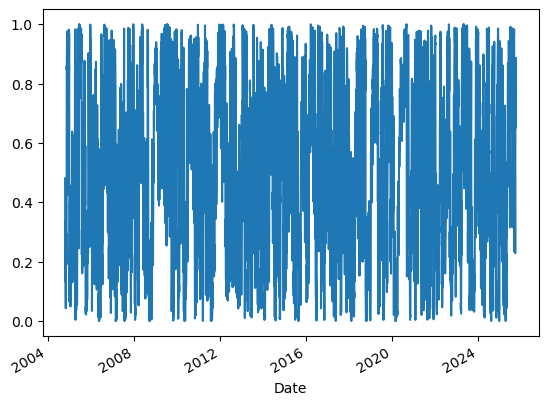

In [38]:
df["cdf"].plot()

In [19]:
th_lo = 0.30
df["trigger_lo"] = (df["cdf"] < th_lo).astype(int) * -1

th_hi = 0.25
df["trigger_hi"] = (df["cdf"] > th_hi).astype(int)

df["trigger"] = df["trigger_lo"] + df["trigger_hi"]

In [20]:
df["R_V0"] = df["V0"].pct_change()
df["R_V0"] = df["R_V0"].fillna(0.)

KeyError: 'V0'

In [ ]:
df["trigger"].plot()

In [ ]:
# on line 92
#
# =MAX(0.0001, O91*(1+(F92*N91)))

# O91 : previous start level

In [ ]:
df["expo"] = df["V0"]/df["VIX_99th"]
df["expo"] = df["expo"].clip(0.20, 1.0)  # <---------- could clip to 25-30% on the low side to maintain exposure

In [ ]:
fig = px.line(df, x=df.index, y='expo', title='Absolute Exposure')
fig.show()